# Simple U-Net with SEBlock for Low Light Image Enhancement

This notebook implements a Simple U-Net model with Squeeze-and-Excitation (SE) blocks to perform low light image enhancement. The notebook is organized into the following sections:

1. **Imports and Setup**: Loading the necessary libraries.
2. **Model Architecture**: Defining the U-Net with SE blocks.
3. **Dataset Definitions**: Implementing custom dataset classes for loading paired images.
4. **Utility Functions and Loss Definitions**: Creating helper functions such as PSNR and loss calculations.
5. **Training Script**: Training and testing the model.

In [13]:
import os
import glob
import math
import argparse

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from pytorch_msssim import ssim
from torchvision import transforms
from PIL import Image


## Model Architecture

The following cell defines the core building blocks of our U-Net model. This includes:

- **SEBlock**: Implements a squeeze-and-excitation module to recalibrate channel-wise features.
- **DoubleConv**: Two consecutive convolution layers with ReLU, followed by an SEBlock.
- **Down and Up**: Modules for downsampling and upsampling, respectively.
- **OutConv**: The final convolutional layer that produces the RGB output.
- **SimpleUNet**: The overall U-Net architecture that connects the encoder, bottleneck, and decoder.

In [14]:
class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation block that learns channel-wise attention.
    """
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        # Squeeze: global average pooling
        y = self.avg_pool(x).view(b, c)  # shape [B, C]
        # Excitation: FC -> ReLU -> FC -> Sigmoid
        y = self.fc(y)                   # shape [B, C]
        y = y.view(b, c, 1, 1)          # reshape for broadcast
        return x * y
    
class DoubleConv(nn.Module):
    """
    A helper module that performs two convolution layers + ReLU.
    We use a 3x3 convolution, stride=1, padding=1 to keep size consistent.
    """
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.se = SEBlock(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.se(x)
        return x
    
class Down(nn.Module):
    """
    Downscale via stride-2 convolution.
    """
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.down = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x):
        x = self.down(x)     # downsample
        x = self.conv(x)     # double conv
        return x

class Up(nn.Module):
    """
    Upscale + DoubleConv.
    """
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        # Pad x to match the size of skip
        diffY = skip.size()[2] - x.size()[2]
        diffX = skip.size()[3] - x.size()[3]
        x = nn.functional.pad(x, (diffX // 2, diffX - diffX//2,
                                  diffY // 2, diffY - diffY//2))

        # Concatenate along channel dimension
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

class OutConv(nn.Module):
    """
    Final output layer: reduce channels to 3 for RGB output.
    """
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class SimpleUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=16):
        super(SimpleUNet, self).__init__()
        # Encoder
        self.inc = DoubleConv(in_channels, features)        
        self.down1 = Down(features, features*2)
        self.down2 = Down(features*2, features*4)
        self.down3 = Down(features*4, features*8)

        # Bottleneck
        self.bottleneck = DoubleConv(features*8, features*16)

        # Decoder
        self.up4 = Up(features*16, features*8)
        self.up3 = Up(features*8, features*4)
        self.up2 = Up(features*4, features*2)
        self.up1 = Up(features*2, features)

        # Final output
        self.outc = OutConv(features, out_channels)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)          # shape [B, 32, H, W]
        x2 = self.down1(x1)       # shape [B, 64, H/2, W/2]
        x3 = self.down2(x2)       # shape [B, 128, H/4, W/4]
        x4 = self.down3(x3)       # shape [B, 256, H/8, W/8]

        # Bottleneck
        xB = self.bottleneck(x4)  # shape [B, 256, H/4, W/4]

        # Decoder
        x = self.up4(xB, x4)      # shape [B, 128, H/2, W/2]
        x = self.up3(x, x3)      # shape [B, 128, H/2, W/2]
        x = self.up2(x, x2)       # shape [B, 64, H, W]
        x = self.up1(x, x1)       # shape [B, 32, H, W]

        # Output
        x = self.outc(x)          # shape [B, 3, H, W]
        return x

## Dataset Definitions

The following dataset classes are used to load paired images (a low-light image and its corresponding normal image) for both training and testing.

- **LLIEPairDataset**: For training data.
- **LLIEPairTestDataset**: For testing data.

In [15]:
class LLIEPairDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        super().__init__()
        self.transform = transform
        self.low_dir = os.path.join(root_dir, 'low')
        self.normal_dir = os.path.join(root_dir, 'normal')
        self.low_images = sorted(glob.glob(os.path.join(self.low_dir, '*.png')))

    def __len__(self):
        return len(self.low_images)

    def __getitem__(self, idx):
        low_path = self.low_images[idx]
        filename = os.path.basename(low_path)
        normal_path = os.path.join(self.normal_dir, filename)
        
        low_img = Image.open(low_path).convert('RGB')
        normal_img = Image.open(normal_path).convert('RGB')
        
        if self.transform:
            low_img = self.transform(low_img)
            normal_img = self.transform(normal_img)
        
        return low_img, normal_img

class LLIEPairTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        super().__init__()
        self.transform = transform
        self.low_dir = os.path.join(root_dir, 'low')
        self.normal_dir = os.path.join(root_dir, 'normal')
        self.low_images = sorted(glob.glob(os.path.join(self.low_dir, '*.png')))

    def __len__(self):
        return len(self.low_images)

    def __getitem__(self, idx):
        low_path = self.low_images[idx]
        filename = os.path.basename(low_path)
        normal_path = os.path.join(self.normal_dir, filename)

        low_img = Image.open(low_path).convert('RGB')
        normal_img = Image.open(normal_path).convert('RGB')

        if self.transform:
            low_img = self.transform(low_img)
            normal_img = self.transform(normal_img)

        return low_img, normal_img

## Utility Functions and Loss Definitions

This cell defines utility functions used to compute evaluation metrics and loss functions. In particular:

- **psnr**: Computes the Peak Signal-to-Noise Ratio.
- **combined_l1_ssim_loss**: Combines L1 loss and (1 - SSIM) as a loss function.
- **test_loop**: Evaluates the model on the test dataset.

In [16]:
def psnr(pred, target):
    mse = nn.MSELoss()(pred, target).item()
    if mse == 0:
        return 100
    return 10 * math.log10(1 / mse)

def combined_l1_ssim_loss(pred, target, alpha=0, beta=1):
    l1 = F.l1_loss(pred, target)
    ssim_val = ssim(pred, target, data_range=1.0)
    return alpha * l1 + beta * (1 - ssim_val)

def test_loop(model, dataloader, device, e, num_epochs):
    model.eval()
    total_l1 = 0.0
    total_psnr = 0.0
    count = 0
    with torch.no_grad():
        for low_img, normal_img in dataloader:
            low_img = low_img.to(device)
            normal_img = normal_img.to(device)

            # Forward pass
            pred = model(low_img)

            # Compute PSNR
            pred_clamped = torch.clamp(pred + low_img, 0, 1)
            total_psnr += psnr(pred_clamped, normal_img)

            # Compute metrics
            l1 = nn.L1Loss()(pred_clamped, normal_img).item()
            total_l1 += l1

            if e == num_epochs - 1:
                pred_image = pred_clamped.squeeze(0).cpu()
                pred_image = pred_image.permute(1, 2, 0).numpy()

                # Display
                fig = plt.figure(frameon=False)
                fig.set_size_inches(6, 4)
                ax = plt.Axes(fig, [0, 0, 1, 1])
                ax.set_axis_off()
                fig.add_axes(ax)
                ax.imshow(pred_image)
                plt.show()

            count += 1

    avg_l1 = total_l1 / count
    avg_psnr = total_psnr / count
    return avg_l1, avg_psnr

## Training Script

The following cell contains the main training script. It uses an argument parser to select between training and testing modes. The model is trained using a combined L1 and SSIM loss and is evaluated on the test dataset. 

**Note**: In a Jupyter Notebook, command-line arguments might not be the ideal approach. You can either modify this cell to remove the parser or run the notebook in an environment that supports argument passing.

Loaded saved model weights.


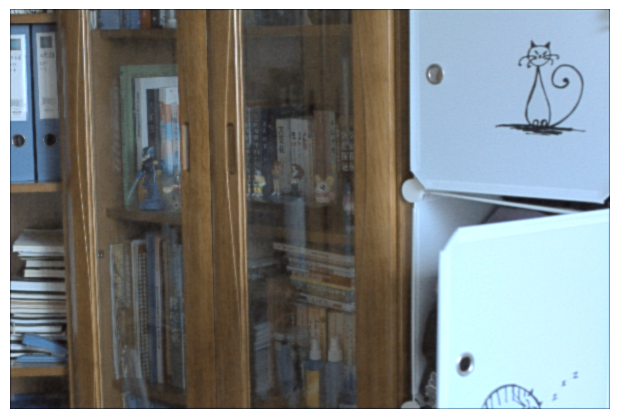

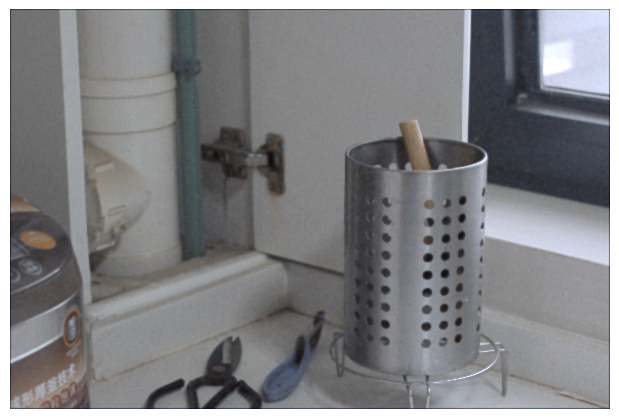

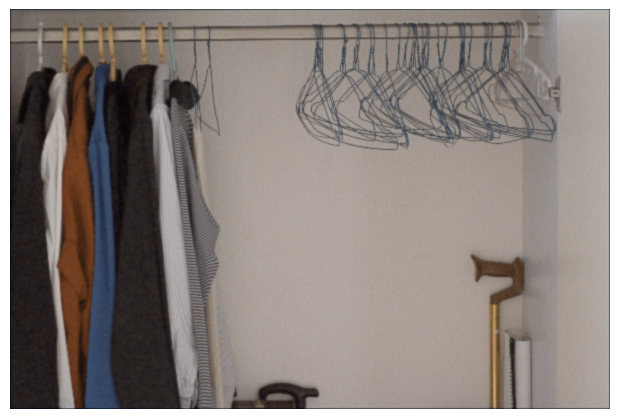

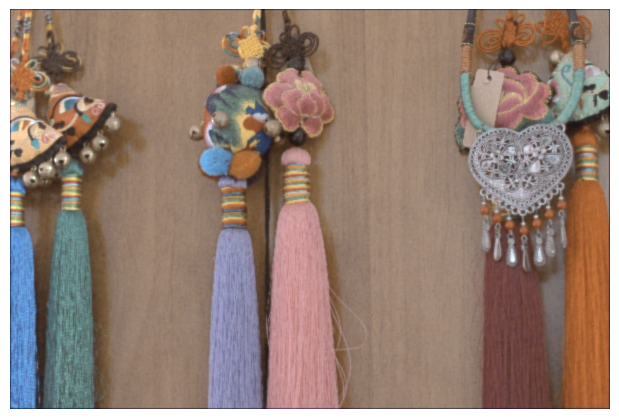

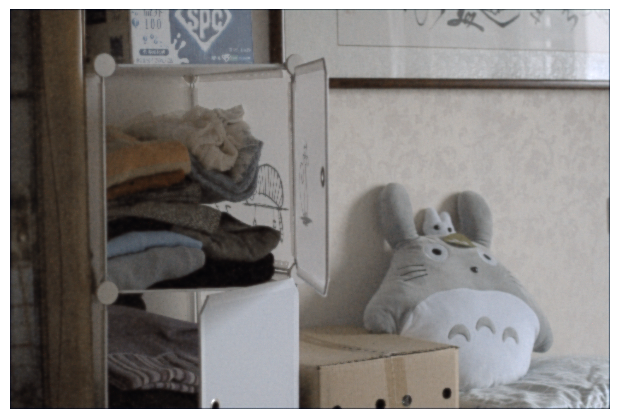

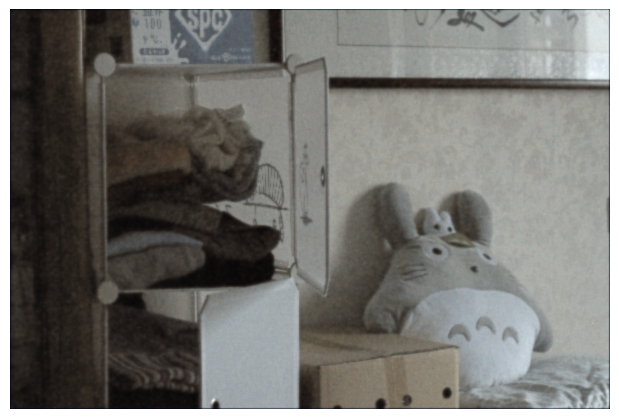

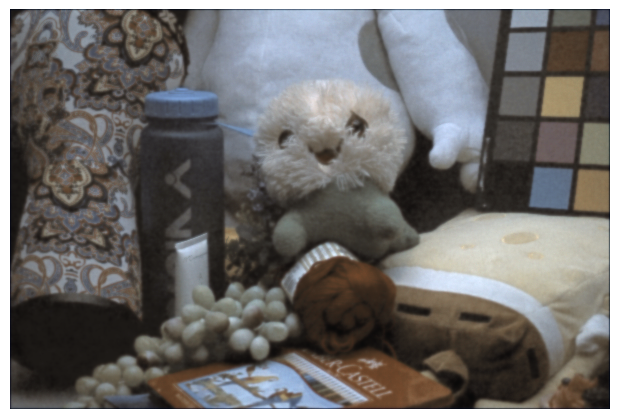

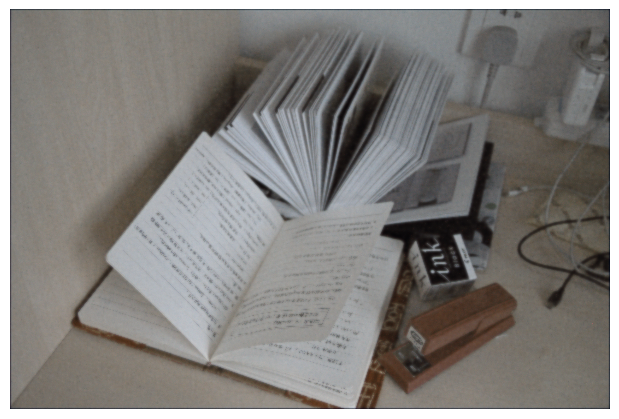

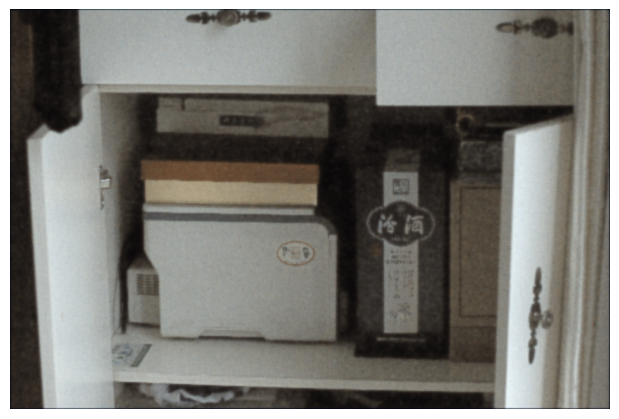

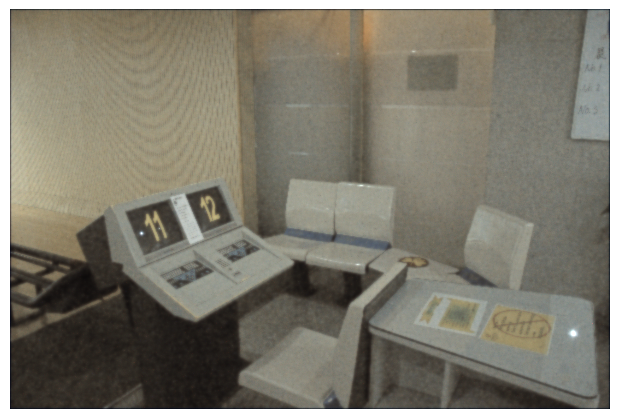

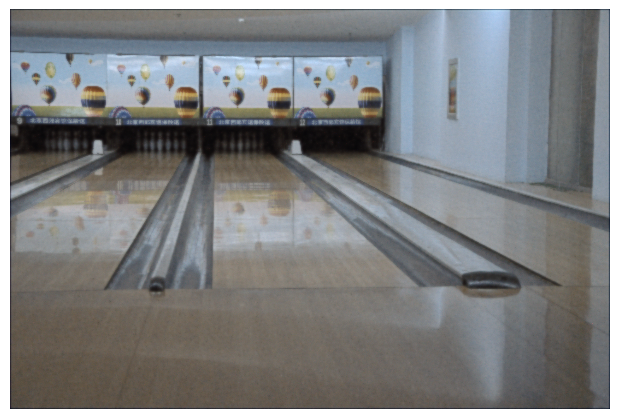

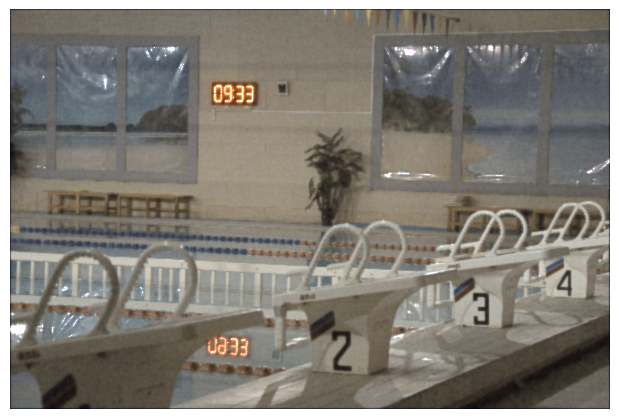

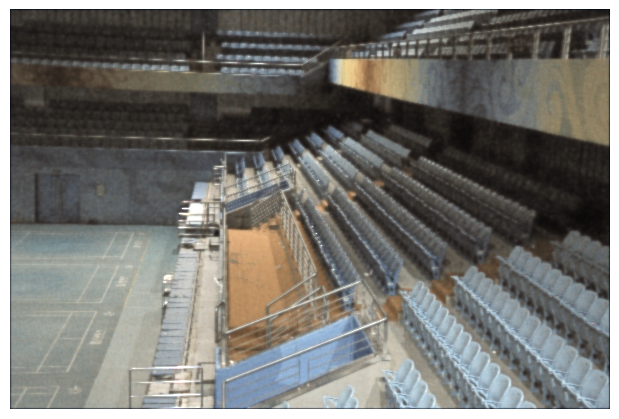

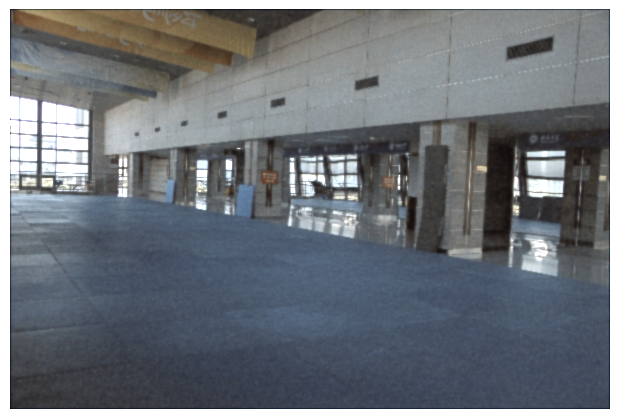

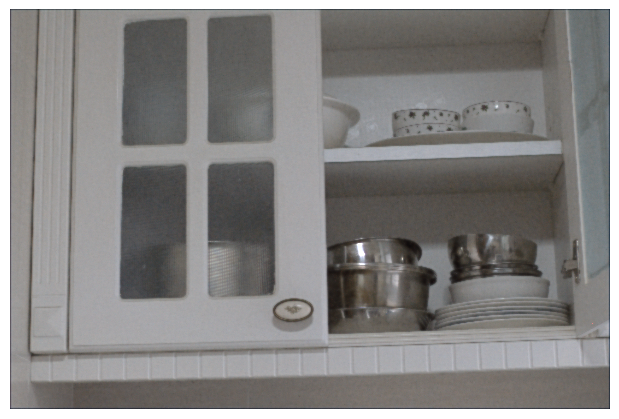

Test L1: 0.1102, Test PSNR: 18.68 dB


In [ ]:
def main(mode):
    # Hyperparameters
    root_dir_train = "LLIE_dataset\\train"
    root_dir_test = "LLIE_dataset\\test"
    batch_size = 3
    num_epochs = 10
    lr = 1e-4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Transforms
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    # Datasets
    train_dataset = LLIEPairDataset(root_dir_train, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)

    test_dataset = LLIEPairTestDataset(root_dir_test, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Model
    model = SimpleUNet(in_channels=3, out_channels=3, features=64).to(device)

    if mode == 'test':
        # Load the pre-trained model weights
        model.load_state_dict(torch.load("simple_unet_llie.pth", map_location=device))
        print("Loaded saved model weights.")

        # Run testing on the test set
        test_l1, test_psnr = test_loop(model, test_loader, device, e=0, num_epochs=1)
        print(f"Test L1: {test_l1:.4f}, Test PSNR: {test_psnr:.2f} dB")
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Training + Testing
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for low_img, normal_img in train_loader:
                low_img = low_img.to(device)
                normal_img = normal_img.to(device)

                # Forward
                pred = model(low_img)
                pred_final = torch.clamp(pred + low_img, 0, 1)
                loss = combined_l1_ssim_loss(pred_final, normal_img)

                # Backward
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            avg_train_loss = running_loss / len(train_loader)

            test_l1, test_psnr = test_loop(model, test_loader, device, epoch, num_epochs)
    
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                f"Train Loss: {avg_train_loss:.4f}, "
                f"Test L1: {test_l1:.4f}, "
                f"Test PSNR: {test_psnr:.2f} dB")

        # Save model
        torch.save(model.state_dict(), "simple_unet_llie.pth")
        print("Model saved.")

# main(mode='train')
main(mode='test')